# Auto-diff modeling of a `MOLET` simulation

### Fit of the smooth source and lens model simultaneously, along with a free offset for sky level

__last updated__: 16/12/21

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import os
import numpy as np
from copy import deepcopy
from astropy.io import fits
from pprint import pprint
import corner
plt.rc('image', interpolation='none')

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# jaxtronomy imports
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Inference.sampling import Sampler
from herculens.Util import image_util, param_util, molet_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
We use convenience functions to setup coordinates directly from MOLET input files.

__WARNING__: update the `model_dir` and possibly other paths to match the directories on your system.

In [2]:
molet_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/molet/'
molet_simu_name = 'mock_4_autodiff_smooth'
#molet_instru_name = 'gaussianCAM

pixel_grid, noise, psf_molet, data_raw, dpsi_map \
    = molet_util.read_molet_simulation(molet_dir, molet_simu_name)

npix, npix_y = pixel_grid.num_pixel_axes
pix_scl = pixel_grid.pixel_width  # arcsec / pixel
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix_y}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (200, 200) pixels
pixel size : 0.04000000000000001 arcsec
x range    : (-3.98, 3.98) arcsec
y range    : (-3.98, 3.98) arcsec


/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:31: UserWarning: Using MOLET instrument 'gaussian_ACS_F814W'.
  warnings.warn(f"Using MOLET instrument '{instrument_name}'.")
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:52: UserWarning: An offset of 0.006 was subtracted from the original MOLET simulation.
  warnings.warn(f"An offset of {offset:.3f} was subtracted from the original MOLET simulation.")
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:138: UserWarning: Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).
  warnings.warn("Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).")


### Load imaging data

-0.005758371543218716


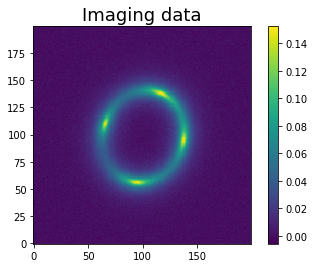

In [3]:
#data_raw = molet_util.get_simulated_data(molet_dir, molet_input_file, molet_instru_name)

# uncomment this line to load a jaxtronomy-generated data
#data_raw = fits.getdata('data/simu_bkg0.01_expNone.fits').astype(float)

print(data_raw.min())

plt.title("Imaging data", fontsize=FS)
plt.imshow(data_raw, origin='lower')
plt.colorbar()
plt.show()

### Noise

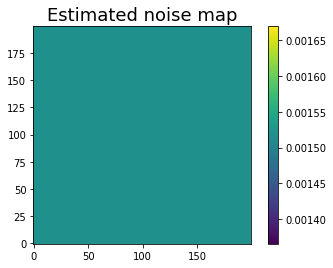

In [4]:
# select a portion believed to contain only noise
#data_sky = data_raw[:, :10]
#mean_sky = np.median(data_sky)

# TEST: can we re-compute the input sky level used in MOLET?
#snr = 100.
#test_mean_sky = - np.min( np.max(data_raw)/snr * np.random.randn(npix, npix) )

# measure background noise
#sigma_bkd = 1.48 * np.median(np.abs(data_sky - np.median(data_sky)))

# remove sky level
data = data_raw # - mean_sky

#print(mean_sky, sigma_bkd, data.max())

#kwargs_noise = {'background_rms': sigma_bkd, 'noise_map': sigma_bkd*np.ones_like(data)}
#noise = Noise(npix, npix, **kwargs_noise)

noise.set_data(data)

plt.title("Estimated noise map", fontsize=FS)
plt.imshow(np.sqrt(noise.C_D), origin='lower')
plt.colorbar()
plt.show()

### PSF

In [5]:
#fwhm = 0.3
fwhm = 0.12

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': pix_scl, 'truncation': 10}
psf = PSF(**kwargs_psf)
#fits.writeto('psf_data_res.fits', psf.kernel_point_source, overwrite=True)

#psf = psf_molet


kwargs_psf_super = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': pix_scl/10., 'truncation': 10}
psf_super = PSF(**kwargs_psf_super)
fits.writeto('psf_TEST.fits', np.array(psf_super.kernel_point_source), overwrite=True)

### True input parameters Source light model

In [6]:
pix_shift = 0. # - pix_scl/2.  # when MOLET PSF is not centered

# Source light
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 0.5, 'n_sersic': 1.5, 'center_x': 0.05 + pix_shift, 'center_y': -0.05 + pix_shift}]

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0 + pix_shift, 'center_y': 0.0 + pix_shift},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = [] #['UNIFORM']
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}] # [{'amp': 0.}]

In [7]:
# difference in degrees in PAs between jaxtronomy and MOLET
# - if RA is positive towards the RIGHT
diff_angle_sie_RA2right = -90
diff_angle_shear_RA2right = -90
# - if RA is positive towards the LEFT
diff_angle_sie_RA2left = +90
diff_angle_shear_RA2left = +90

# warning: change accordingly the source position along the x-axis !

phi, q = param_util.ellipticity2phi_q(kwargs_lens_mass[0]['e1'], kwargs_lens_mass[0]['e2'])
print(phi*180./np.pi + diff_angle_sie_RA2left, q)
psi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_lens_mass[1]['gamma1'], kwargs_lens_mass[1]['gamma2'])
print(psi_ext*180./np.pi + diff_angle_shear_RA2left, gamma_ext)

82.53429141093122 0.7312393750126034
144.217474411461 0.03162277660168379


## Prepare for fitting

### Parameter class

We set our initial values for the parameters we want to optimise, and set fixed parameters (here we fix source parameters to the truth). We also set possible priors among `'uniform'` and `'gaussian'` for a subset of parameters.

In [8]:
kwargs_numerics = {'supersampling_factor': 3, 'convolution_type': 'grid'}

lens_image = LensImage(pixel_grid, psf,
                         noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.6, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': 1e-3, 'gamma2': 1e-3}],
    'kwargs_source': [{'amp': 10., 'R_sersic': 0.5, 'n_sersic': 1.5, 'center_x': 0.05, 'center_y': -0.05}],
    'kwargs_lens_light': [{'amp': 0.}],
}
kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['uniform', 1.2, 2.0], 'e1': ['uniform', -0.3, 0.3], 'e2': ['uniform', -0.3, 0.3], 'center_x': ['uniform', -0.2, 0.2], 'center_y': ['uniform', -0.2, 0.2]}, {'gamma1': ['uniform', -0.3, 0.3], 'gamma2': ['uniform', -0.3, 0.3]}],
    'kwargs_source': [{'amp': ['uniform', 1., 30.], 'R_sersic': ['uniform', 1.1, 1.3], 'n_sersic': ['uniform', 1.4, 1.6], 'center_x': ['uniform', -0.6, 0.6], 'center_y': ['uniform', -0.6, 0.6]}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],  # fix origin of the external shear profile
    #'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],  # fix origin of the external shear profile
    #'kwargs_source': [{'amp': 10.}],
    'kwargs_source': [{}],
    #'kwargs_source': [{'R_sersic': kwargs_source_light[0]['R_sersic'], 'n_sersic': kwargs_source_light[0]['n_sersic']}],
    'kwargs_lens_light': [{}],
    #'kwargs_lens_light': [{'amp': 0.}],
}
parameters = Parameters(lens_image, kwargs_init, kwargs_fixed, 
                        kwargs_prior=kwargs_prior)

kwargs_true = {'kwargs_lens': kwargs_lens_mass, 'kwargs_source': kwargs_source_light, 'kwargs_lens_light': kwargs_lens_light}
p_true = deepcopy(parameters.kwargs2args(kwargs_true))
param_names = parameters.names
print("truths:", p_true, param_names, len(p_true))

print("prior types:", parameters.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters.bounds)

truths: [ 1.6   0.15 -0.04 -0.02 -0.02 -0.01  0.03 10.    0.5   1.5   0.03 -0.07] ['theta_E', 'e1', 'e2', 'center_x', 'center_y', 'gamma1', 'gamma2', 'amp', 'R_sersic', 'n_sersic', 'center_x', 'center_y'] 12
prior types: ['uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform']
lower/upper bounds (for uniform priors): [ 1.2 -0.3 -0.3 -0.2 -0.2 -0.3 -0.3  1.   1.1  1.4 -0.6 -0.6] [ 2.   0.3  0.3  0.2  0.2  0.3  0.3 30.   1.3  1.6  0.6  0.6]


### Visualise initial model

2638.3477300487416


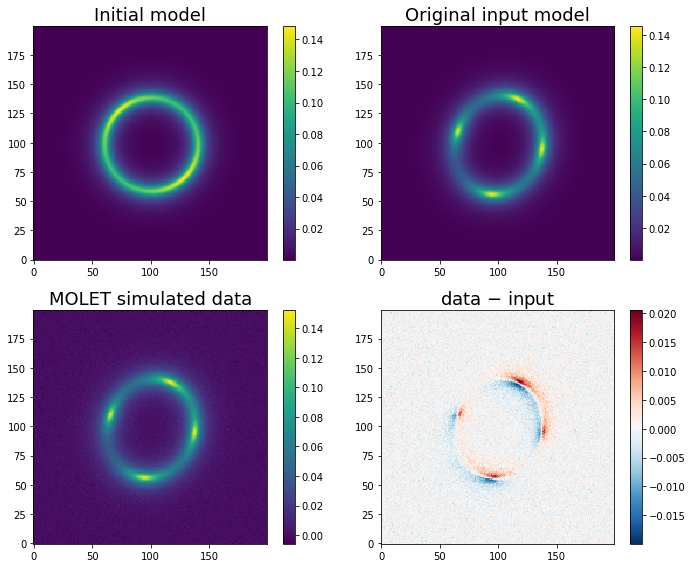

In [9]:
# Generate a lensed image based on source and lens models
image = lens_image.model(**kwargs_init)
image_input = lens_image.model(**kwargs_true)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax = axes[0, 0]
ax.set_title("Initial model", fontsize=FS)
img = ax.imshow(image, origin='lower')
fig.colorbar(img, ax=ax)
ax = axes[0, 1]
ax.set_title("Original input model", fontsize=FS)
img = ax.imshow(image_input, origin='lower')
fig.colorbar(img, ax=ax)
ax = axes[1, 0]
ax.set_title("MOLET simulated data", fontsize=FS)
img = ax.imshow(data, origin='lower')
fig.colorbar(img, ax=ax)
ax = axes[1, 1]
ax.set_title("data $-$ input", fontsize=FS)
#img = ax.imshow(data/data.mean()-image_input/image_input.mean(), origin='lower', cmap='RdBu_r', vmin=-3, vmax=3)
img = ax.imshow(data-image_input, origin='lower', cmap='RdBu_r')
fig.colorbar(img, ax=ax)
fig.tight_layout()

print(np.sum((data/data.mean()-image_input/image_input.mean())**2))

### Loss function

In [10]:
loss = Loss(data, lens_image, parameters, likelihood_type='chi2')

### Minimize the loss function

The following method calls `scipy.optimize.mininize`. Supported methods are:
- `'Nelder-Mead'`: uses no analytical gradient;
- `'BFGS'`: uses gradient;
- `'Newton-CG'`/`'trust-krylov'`/`'trust-constr'`: uses gradient and hessian-vector product. In addition, `'trust-constr'` uses bounds from uniform prior consistently within the optimization;
- `'trust-exact'` (uses gradient and hessian).

By setting `use_exact_hessian_if_allowed=True` it is possible to force methods that use the hessian-vector product to use the full hessian instead.

In [11]:
optimizer = Optimizer(loss, parameters)

Check loss and its first derivative evaluated to the true parameters

In [12]:
print(optimizer.loss(p_true))
#print(optimizer.jacobian(p_true))

1.938312845894665


In [13]:
# Optimise !
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='trust-krylov', restart_from_init=True)
print(f"Runtime: {runtime}")
kwargs_final = deepcopy(parameters.current_values(as_kwargs=True))
pprint(kwargs_final)
#print(extra_fields['result_class'])  # uncomment for full scipy summary

Runtime: 33.83812403678894
{'kwargs_lens': [{'center_x': array(0.00095476),
                  'center_y': array(-0.00047721),
                  'e1': array(0.14465756),
                  'e2': array(-0.03729751),
                  'theta_E': array(1.59911195)},
                 {'dec_0': 0.0,
                  'gamma1': array(-0.01163815),
                  'gamma2': array(0.03081378),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [],
 'kwargs_source': [{'R_sersic': array(0.5101053),
                    'amp': array(9.50878389),
                    'center_x': array(0.05039792),
                    'center_y': array(-0.04952641),
                    'n_sersic': array(1.56188691)}]}


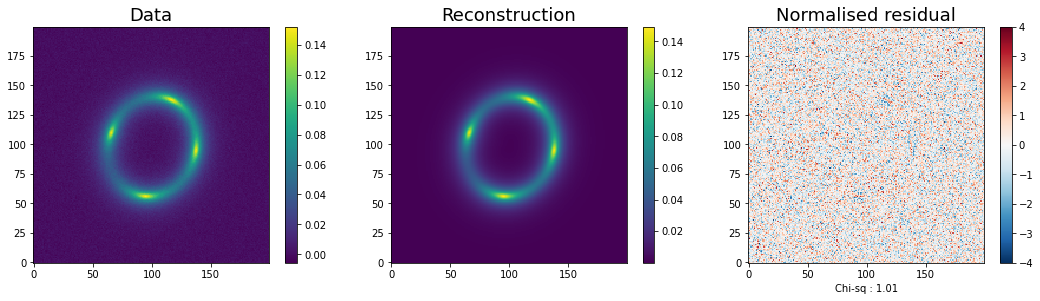

In [14]:
def plot_image_model(kwargs):
    rec = lens_image.model(**kwargs)
    noise_var = lens_image.Noise.C_D

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec, origin='lower')
    ax2.set_title("Reconstruction", fontsize=FS)
    img3 = ax3.imshow((data - rec) / jnp.sqrt(noise_var), origin='lower', vmin=-4, vmax=4, cmap='RdBu_r')
    ax3.set_title("Normalised residual", fontsize=FS)
    red_chi2 = np.mean((data - rec)**2 / noise_var)
    ax3.set_xlabel(f"Chi-sq : {red_chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()
    
plot_image_model(kwargs_final)

In [15]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} % ({value} => {estimate})")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} [abs] ({value} => {estimate})")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
    for i, params in enumerate(kwargs_source_light):
        for key, value in params.items():
            fit = kwargs['kwargs_source'][i][key]
            _print_error(key, value, fit)
    for i, params in enumerate(kwargs_lens_light):
        for key, value in params.items():
            fit = kwargs['kwargs_lens_light'][i][key]
            _print_error(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
theta_E:   0.06 % (1.6 => 1.5991119532245095)
e1:        3.56 % (0.15 => 0.14465756189975737)
e2:        -6.76 % (-0.04 => -0.03729750601922043)
center_x:  -104.77 % (-0.020000000000000004 => 0.0009547612895248908)
center_y:  -97.61 % (-0.020000000000000004 => -0.00047721090171999885)
gamma1:    -16.38 % (-0.01 => -0.011638150453721494)
gamma2:    2.71 % (0.03 => 0.030813780364475428)
ra_0:      0.00 [abs] (0.0 => 0.0)
dec_0:     0.00 [abs] (0.0 => 0.0)
amp:       4.91 % (10.0 => 9.508783890395492)
R_sersic:  2.02 % (0.5 => 0.5101053046172636)
n_sersic:  4.13 % (1.5 => 1.561886914841885)
center_x:  67.99 % (0.03 => 0.05039791969256663)
center_y:  -29.25 % (-0.07 => -0.049526411483685216)


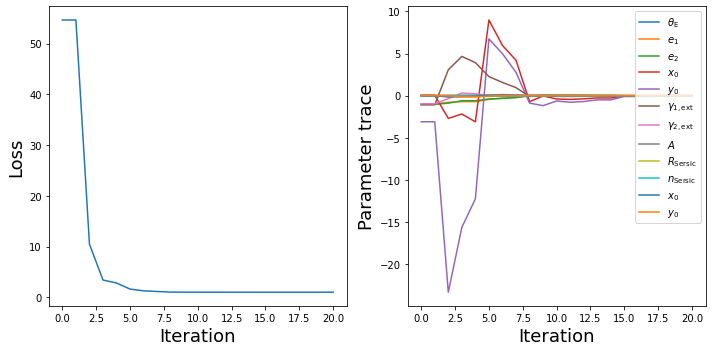

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(extra_fields['param_history'])
for i in range(len(param_names)):
    ax.plot(range(len(extra_fields['loss_history'])), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Check coordinates offsets with MOLET

mass offset, x: 0.020954761289524896
mass offset, y: 0.019522789098280004
source offset, x: 0.02039791969256663
source offset, y: 0.02047358851631479


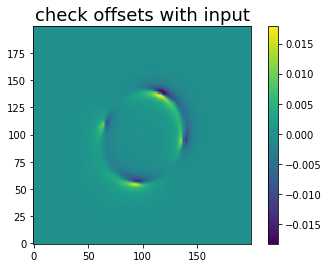

In [17]:
print("mass offset, x:", kwargs_final['kwargs_lens'][0]['center_x'] - kwargs_true['kwargs_lens'][0]['center_x'])
print("mass offset, y:", kwargs_final['kwargs_lens'][0]['center_y'] - kwargs_true['kwargs_lens'][0]['center_y'])
print("source offset, x:", kwargs_final['kwargs_source'][0]['center_x'] - kwargs_true['kwargs_source'][0]['center_x'])
print("source offset, y:", kwargs_final['kwargs_source'][0]['center_y'] - kwargs_true['kwargs_source'][0]['center_y'])

# take optimized parameter but fix all centroids to true input values
kwargs_checkoffset = deepcopy(kwargs_final)
kwargs_checkoffset['kwargs_lens'][0]['center_x'] = kwargs_true['kwargs_lens'][0]['center_x']
kwargs_checkoffset['kwargs_lens'][0]['center_y'] = kwargs_true['kwargs_lens'][0]['center_y']
kwargs_checkoffset['kwargs_source'][0]['center_x'] = kwargs_true['kwargs_source'][0]['center_x']
kwargs_checkoffset['kwargs_source'][0]['center_y'] = kwargs_true['kwargs_source'][0]['center_y']

image_final = lens_image.model(**kwargs_final)
image_checkoffset = lens_image.model(**kwargs_checkoffset)

plt.title("check offsets with input", fontsize=FS)
plt.imshow(image_checkoffset - image_final, origin='lower')
plt.colorbar()
plt.show()

In [18]:
raise

RuntimeError: No active exception to reraise

### Fisher matrix & approximated posteriors

In [ ]:
if extra_fields['hess_inv'] is not None:
    print("Using approximated inverse Hessian")
    fisher_matrix = extra_fields['hess_inv']
    
else:
    # 1) either we use the true hessian
    print("Using true inverse Hessian")
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)
    
    # 2) or we re-run the BFGS optimizer from the previous estimate to approximate it
    # print("Approximating inverse Hessian with a BFGS run")
    #_, _, extra_fields_bfgs, _ \
    #    = optimizer.minimize(method='BFGS', restart_from_init=False)
    #fisher_matrix = extra_fields_bfgs['hess_inv']

sqrt_fisher_matrix = np.sqrt(np.abs(fisher_matrix)) * np.sign(fisher_matrix)
plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
plt.imshow(sqrt_fisher_matrix, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix).max(), vmax=np.abs(sqrt_fisher_matrix).max())
plt.xticks(range(parameters.num_parameters), parameters.symbols, rotation='vertical', fontsize=12)
plt.yticks(range(parameters.num_parameters), parameters.symbols, rotation='horizontal', fontsize=12)
plt.colorbar(label="parameter standard deviation")
plt.show()

In [ ]:
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

if fisher_matrix is not None:
    samples_fisher = draw_from_gaussian(best_fit, fisher_matrix, ndraws=10000)

    fig = plt.figure(figsize=(15, 15))
    fig = corner.corner(samples_fisher, truths=p_true, show_titles=True, labels=parameters.symbols,
                        #range=0.1*np.array(parameters.bounds).T
                        fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
    plt.show()